In [57]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pathlib
import matplotlib as mpl 
import os,h5py
from seaborn import color_palette
mpl.rc('text', usetex = False)
import seaborn as sns
from scipy.fft import rfftn, irfftn,fftfreq

## Simulation details

In [94]:
N = 128
num_slabs = 256
nu0 = 0.8 #! Viscosity for N = 1
lp = 8
m = 2.0 #! Desired kmax*eta
nu = nu0*(3*m/N)**(2*(lp - 1/3)) #? scaling with resolution. For 512, nu = 0.002 with m = 2#! Need to add scaling for hyperviscosity
# nu0 = 8.192 #! Viscosity for N = 1
# nu0 = 4.714 #! Viscosity from Pope's 256 run 
# nu = nu0/(N**(4/3))  #? scaling with resolution. For 512, nu = 0.002 #! Need to add scaling for hyperviscosity
isforcing = True
eta = 2/(N//3)
nshells = 2 

f0 = (nu0**3) 
f0,nu

(0.5120000000000001, 3.3434099065213628e-21)

In [3]:
u = np.zeros((3,N,N,N),dtype=np.float64)
with h5py.File("/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/data/forced_True/N_256_Re_270.5/time_40.0/Fields.hdf5","r") as f:
    u[0] = f['u']
    u[1] = f['v']
    u[2] = f['w']
    ek_arr = f['Energy_Spectrum'][:]
    for attr_name, attr_value in f.attrs.items():
        print(f"{attr_name}: {attr_value}")

N: 256
Power input: 0.529320987654321
eta: 0.01764705882352941
forcing: Isotropic with const power input in shells [1]
nu: 0.003697172970758739
t_eta: 0.08357479646190688


In [28]:
P = 0.529320987654321

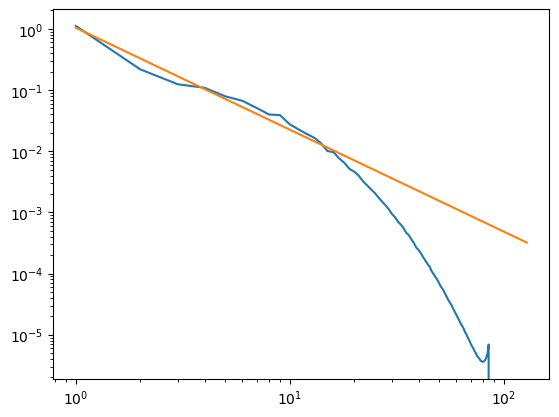

In [34]:
k = np.arange(1,ek_arr.size)
plt.plot(k,ek_arr[1:]/TWO_PI**3)
plt.plot(k, 1.6*P**(2/3)*k**(-5/3) )
plt.xscale("log")
plt.yscale("log")

In [9]:
uk = rfftn(u, axes=(-3,-2,-1))
omgz = irfftn(1j*(ky*uk[0] - kx*uk[1]), (N,N,N),axes=(-3,-2,-1))
omgy = irfftn(1j*(kz*uk[0] - kx*uk[2]), (N,N,N),axes=(-3,-2,-1))
omgx = irfftn(1j*(ky*uk[2] - kz*uk[1]), (N,N,N),axes=(-3,-2,-1))
omg_rms = omgz.std()
div = irfftn(1j*(kx*uk[0] + ky*uk[1] + kz*uk[2]), (N,N,N),axes=(-3,-2,-1))

In [10]:
div.min(),u.std()

(np.float64(-2.895643351757641e-13), np.float64(1.159996481722911))

In [11]:
u = np.zeros((3,N,N,N),dtype=np.float64)
with h5py.File(f"/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/data/forced_True/N_256_Re_270.5/time_40.0/st_{0.01}/n.hdf5","r") as f:
    n = f['n'][:]
    for attr_name, attr_value in f.attrs.items():
        print(f"{attr_name}: {attr_value}")

t_f: 0.08357479646190688
t_p: 0.0008357479646190688


In [12]:
n.mean()

np.float64(1.000000000000011)

In [17]:
def coarse_grain(x,npts = 3):
    kernel = np.ones((npts, npts, npts)) / (npts)**3  # 3x3x3 averaging

    # Apply convolution to compute running averages
    coarse_x = sp.ndimage.convolve(x, kernel, mode='wrap', cval=0.0)
    return coarse_x

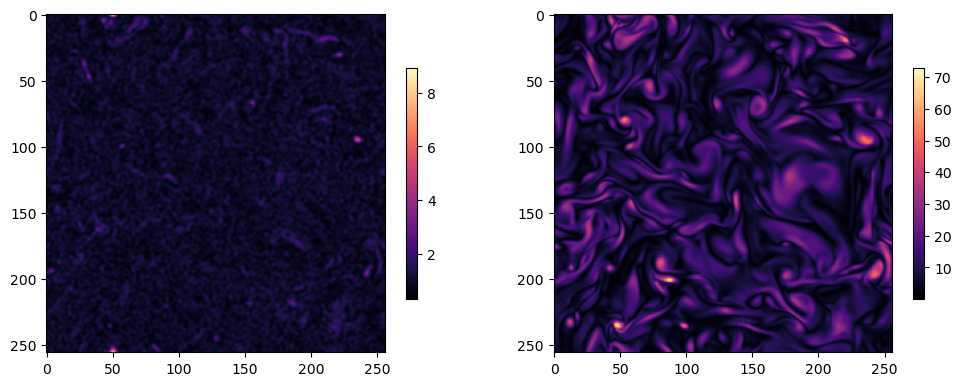

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
p1 = ax[0].imshow(coarse_grain(n)[...,128],cmap = "magma")
plt.colorbar(p1,shrink = 0.5)
# ax[1].imshow(u[0,20],cmap = "RdYlBu")
p2 = ax[1].imshow(np.abs((omgz** 2 + omgy**2 + omgx**2)[...,128])**0.5,cmap = "magma")
plt.colorbar(p2,shrink = 0.5)


In [95]:
PI = np.pi
TWO_PI = 2*PI
Nf = N//2 + 1
Nd = np.round(2/3**0.5*Nf,0).astype(int)
Np = N
L = TWO_PI
X = Y = Z = np.linspace(0, L, N, endpoint= False)
dx,dy,dz = X[1]-X[0], Y[1]-Y[0], Z[1]-Z[0]


Kx = Ky = Kz = fftfreq(N,  1./N)*TWO_PI/L
Kz = np.abs(Kz[:Nf])

In [96]:
loadPath = lambda t : pathlib.Path(f"/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/data/forced_{isforcing}/N_{N}_Re_{1/nu:.1f}/time_{t:.1f}")
# loadPath = lambda t : pathlib.Path(f"/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/data/forced_True/N_256_Re_184.3/mrinal/time_{t:.1f}")
# loadPath = lambda t : pathlib.Path(f"/mnt/pfs/ritwik.mukherjee/HIT_3D/data/forced_{isforcing}/N_{N}_Re_1259.9/time_{t:.1f}")
# loadPath = lambda t : pathlib.Path(f"/home/rajarshi.chattopadhyay/python/3D-DNS/data/forced/N_128_Re_600.0/time_{t:.1f}")
# loadPath = lambda t : pathlib.Path(f"./data/forced_{isforcing}/N_{N}_Re_{1/nu:.1f}/time_{t:.1f}")
print(loadPath(0).exists())
# print(os.listdir((loadPath(0).parent.parent)))
# "/mnt/pfs/rajarshi.chattopadhyay/3D-DNS/data/forced_True/N_128_Re_200.0/time_0.0"

True


In [97]:
times = [float(i.split("_")[-1]) for i in os.listdir(loadPath(0).parent) if "time" in i]
times.sort()
times = np.array(times)
times[-1]

np.float64(20.0)

# <center> Loading the velocity field 

In [6]:
x, y, z = np.meshgrid(X, Y, Z, indexing='ij')

kx,  ky,  kz = np.meshgrid(Kx,  Ky,  Kz,  indexing = 'ij')
k = (kx**2 + ky**2 + kz**2)**0.5
cond_ky = np.abs(np.round(Ky))<=N//3
cond_kz = np.abs(np.round(Kz))<=N//3

NameError: name 'X' is not defined

In [8]:
uk = np.zeros((3,N,N,N//2 + 1), dtype= np.complex128)
for i in range(N):
    uk[...,i,:] = np.load(loadPath(36)/f"Fields_{i}.npz")["uhat"][...,0,:]

In [9]:
x1 = np.real(uk[0,3,1,0]) 
x2 = np.real(uk[0,-3,-1,0])
y1 = np.imag(uk[0,3,1,0]) 
y2 = np.imag(uk[0,-3,-1,0])

In [13]:
(x1 -x2)/x1

np.float64(-1.0653744349719819e-10)

In [11]:
(y1+y2)/y1

np.float64(-5.791420508431849e-11)

In [26]:

# np.load(f"/mnt/pfs/rajarshi.chattopadhyay/3D-DNS/data/zero-start/time_10.0/Fields_56.npz")["u"].shape
# times = np.array(list(np.arange(0,200.5,10)) )#+  list(np.arange(50.9,100.5,1.0)))


In [44]:
paths = loadPath(15.0)


cond_ky = np.abs(np.round(Ky))<=N//3

def load_trunc(x):
    x1 = np.zeros((*x.shape[:-2],N,Nf),dtype = np.complex128)
    x1[...,cond_ky,:x.shape[-1]] = x.copy()
    return irfftn(x1,(N,N), axes = (-2,-1))


u = np.zeros((3,N,N,N))

load_num_slabs = len([x for x in (paths).iterdir() if "Fields" in str(x)])
data_per_rank = N//load_num_slabs
rank = 0
rank_data = range(rank*Np,(rank + 1)*Np) # The rank contains these slices 
slab_old = np.inf


for lidx,j in enumerate(rank_data):
    slab = j//data_per_rank
    idx = j%data_per_rank
    

    """Loading the truncated data"""
    if slab_old != slab:  Field = np.load(paths/f"Fields_cmp_{slab}.npz")
    slab_old = slab
    
    # u_slab = load_trunc(Field['u'][idx])
    # v_slab = load_trunc(Field['v'][idx])
    # w_slab = load_trunc(Field['w'][idx])
    # break
    
    u[0,lidx] = load_trunc(Field['u'][idx])
    u[1,lidx] = load_trunc(Field['v'][idx])
    u[2,lidx] = load_trunc(Field['w'][idx])

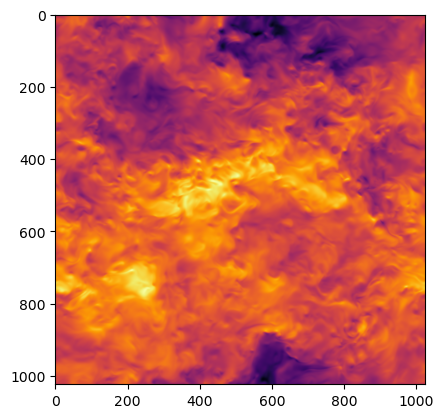

In [43]:
plt.imshow(w_slab, cmap = 'inferno')

In [45]:
kvec = np.array([kx,ky,kz])


In [46]:
uk = rfftn(u, axes=(-3,-2,-1))
omgz = irfftn(1j*(ky*uk[0] - kx*uk[1]), (N,N,N),axes=(-3,-2,-1))
omg_rms = omgz.std()
div = irfftn(1j*(kx*uk[0] + ky*uk[1] + kz*uk[2]), (N,N,N),axes=(-3,-2,-1))

In [52]:
omg_rms = omgz.std()
omg_rms = 13.620898637775898

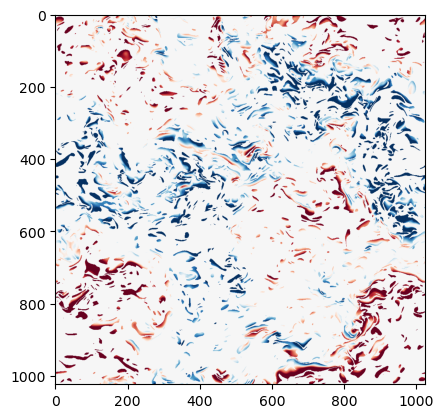

In [63]:
plt.imshow(np.where(np.abs(omgz[0])> omg_rms, u[0,0], 0), cmap = 'RdBu',vmin = -1, vmax = 1)

In [43]:
u_new = np.moveaxis(u,[0,1,2,3],[0,3,2,1]) 
uk_new = rfftn(u_new, axes=(-3,-2,-1))
div_new = irfftn(1j*(kx*uk_new[0] + ky*uk_new[1] + kz*uk_new[2]), (N,N,N),axes=(-3,-2,-1))

In [44]:
div.std()/omgz.std()

(np.float64(9.259195368781162e-15), np.float64(0.8936551018380078))

In [30]:
t = 2.0
Ns= N//num_slabs
for i in range(num_slabs):
    data = np.load(loadPath(t)/f"Fields_{i}.npz")
    u[i*Ns:(i+1)*Ns] = data["u"]
    print(f"done for slab {i}",end = "\r")

In [46]:
import subprocess

cmap= color_palette("icefire",as_cmap=True)
norm = mpl.colors.TwoSlopeNorm(vcenter = 0)
# p1 = plt.imshow(u[...,0],cmap = cmap,alpha = 0.9)
# plt.colorbar(p1)
output_dir = pathlib.Path("/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images")
output_dir.mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(10, 10), dpi=300)
plt.axis('off')
plt.gca().set_facecolor('none')
plt.gca().set_alpha(0)
for zslab in range(N):
    p1 = plt.imshow(u[..., zslab], cmap=cmap, norm=norm, alpha=1.0)
    cbar = plt.colorbar(p1, shrink=0.5)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    plt.title(f"Z-slab {zslab}")
    plt.tight_layout()
    plt.savefig(output_dir / f"zslab_{zslab}.png",transparent = True)
    plt.clf()
    print(f"Done for slab {zslab}", end="\r")
# Run the ffmpeg command


<Figure size 3000x3000 with 0 Axes>

In [48]:
subprocess.run([
    'ffmpeg', '-framerate', '60', '-i', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/zslab_%d.png',
    '-vcodec', 'libx265', '-pix_fmt', 'yuv420p', '-crf', '1', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/z_span.mp4'
])

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-1)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopen

CompletedProcess(args=['ffmpeg', '-framerate', '60', '-i', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/zslab_%d.png', '-vcodec', 'libx265', '-pix_fmt', 'yuv420p', '-crf', '1', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/z_span.mp4'], returncode=0)

# <center> Time series + Kolmogorov Length scale

In [98]:
tload = times
ke = np.zeros(len(tload))
ens = np.zeros(len(tload))
dissip = np.zeros(len(tload))
pe = np.zeros(len(tload))
eta = np.zeros(len(tload))
k1d = np.arange(Nf).astype(np.float64)
for ii,t in enumerate(tload):
    print('Loading Done for time:',t,end = '\r')

    # ke[ii] = np.sum(np.load(loadPath(t)/f"KE_spectrum.npz")["ek"])
    ek = np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]
    ke[ii] = np.sum(ek)
    ens[ii] = np.sum(np.arange(N//2 +1 )**(2)*ek)
    dissip[ii] =  2*nu*np.sum(k1d**(lp*2)*ek)/TWO_PI**3
    eta[ii] = (nu**3/ dissip[ii])**(1/(6.0*lp - 2.0))
    # pe[ii] = np.sum(np.load(loadPath(t)/f"PE_spectrum.npz")["ek"])

In [99]:
dissip
eta*N/3

array([3.73904826, 2.23555273, 2.0967712 , 2.02773959, 1.99012819,
       1.98422513, 1.9947379 , 2.00143103, 2.0017725 , 2.0034718 ,
       2.0040873 , 2.00192416, 1.99909094, 2.00100153, 2.00210001,
       1.99958483, 1.99564791, 1.99572735, 2.00231371, 2.00364324,
       2.0071193 ])

In [7]:
# t_256 = tload
# ke_256 = ke/(TWO_PI**3)
# dissip_256 = 2*nu*ens/(TWO_PI**3)
# kmax_eta_256 = eta*(N//3)

In [8]:
# t_128 = tload
# ke_128 = ke/(TWO_PI**3)
# dissip_128 = 2*nu*ens/(TWO_PI**3)
# kmax_eta_128 = eta*(N//3)

In [9]:
# t_128_pope = tload
# ke_128_pope = ke/(TWO_PI**3)
# dissip_128_pope = 2*nu*ens/(TWO_PI**3)
# kmax_eta_128_pope = eta*(N//3)

In [10]:
# t_256_pope = tload
# ke_256_pope = ke/(TWO_PI**3)
# dissip_256_pope = 2*nu*ens/(TWO_PI**3)
# kmax_eta_256_pope = eta*(N//3)

In [11]:
# t_512 = tload
# ke_512 = ke/(TWO_PI**3)
# dissip_512 = 2*nu*ens/(TWO_PI**3)
# kmax_eta_512 = eta*(N//3)

In [12]:
# t_256_2_shell = tload
# ke_256_2_shell = ke/(TWO_PI**3)
# dissip_256_2_shell = 2*nu*ens/(TWO_PI**3)
# kmax_eta_256_2_shell = eta*(N//3)

In [13]:
# t_128_2_shell = tload
# ke_128_2_shell = ke/(TWO_PI**3)
# dissip_128_2_shell = 2*nu*ens/(TWO_PI**3)
# kmax_eta_128_2_shell = eta*(N//3)

In [14]:


# legends = ["128_pope","256_pope","512","256_2_shell","128_2_shell","256","128"]
# times = [t_128_pope,t_256_pope,t_512,t_256_2_shell,t_128_2_shell,t_256,t_128]
# kes = [ke_128_pope,ke_256_pope,ke_512,ke_256_2_shell,ke_128_2_shell,ke_256,ke_128]
# dissips = [dissip_128_pope,dissip_256_pope,dissip_512,dissip_256_2_shell,dissip_128_2_shell,dissip_256,dissip_128]
# kmax_etas = [kmax_eta_128_pope,kmax_eta_256_pope,kmax_eta_512,kmax_eta_256_2_shell,kmax_eta_128_2_shell,kmax_eta_256,kmax_eta_128]


In [15]:
# nus = [nu0/(N**(4/3)) for N in [128,256,512,256,128,256,128]]
# nus[0] = nus[0]/8.192*4.714
# nus[1] = nus[0]/8.192*4.714

In [16]:
# with h5py.File('/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/data/data_dets.h5', 'w') as f:
#     for i,name in enumerate(legends):
#         f.create_group(name)
#         f[name].create_dataset("time", data= times[i])
#         f[name].create_dataset("ke", data= kes[i])
#         f[name].create_dataset("dissip", data= dissips[i])
#         f[name].create_dataset("kmax_eta", data= kmax_etas[i])
#         f[name].attrs['nu'] = nus[i]
#         f[name].attrs['Re'] = 1/nus[i]
        
        

In [17]:


# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# handles = []
# # Plot 1
# for i,leg in enumerate(legends):
#     h1, = axs[0].plot( times[i],kes[i],'.-', label= legends[i])
#     axs[1].plot( times[i],dissips[i],'.-')
#     axs[2].plot( times[i],kmax_etas[i],'.-')
#     handles.append(h1)
# axs[0].set_xlabel('$t$')
# axs[0].set_ylabel('$E$',rotation = 0)

# axs[1].set_xlabel('$t$')
# axs[1].set_ylabel('$\epsilon$',rotation = 0)


# axs[2].set_xlabel('$t$')
# axs[2].set_ylabel('$k_g\eta$',rotation = 0)

# fig.legend(handles,legends, ncols = len(legends), bbox_to_anchor = (0.5,1.05),loc = "upper center")

# plt.tight_layout()
# plt.show()


In [54]:
1/(2/3*ke/TWO_PI**3)**(-0.5)

array([0.81649658, 0.89037755, 0.95290387, 1.00142003, 1.03604773,
       1.05640677, 1.0619451 , 1.05314687, 1.03392358, 1.01150374,
       0.98782087, 0.96748273, 0.95321716, 0.94677583, 0.94758321,
       0.9540153 , 0.96253529, 0.96999124, 0.97608276, 0.97992393,
       0.9806329 , 0.97894299, 0.9760273 , 0.97352121, 0.97219139,
       0.97076806, 0.9693691 , 0.96604828, 0.96062006, 0.95567074,
       0.95396179, 0.95646483, 0.96149621, 0.96565101, 0.96977067,
       0.9741052 , 0.97788466, 0.98137293, 0.98509148, 0.98773964,
       0.98843736])

In [55]:
# ke_128 = ke

/tmp/ipykernel_383786/3393032543.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, '$E$')

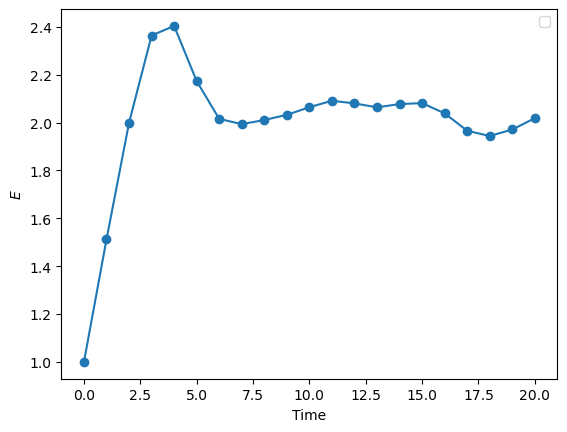

In [100]:
# plt.plot(tload,eta,'x-')
# t_256 = np.arange(ke_256.size)*0.5
# t_128 = np.arange(ke_128.size)*0.5
plt.plot(tload,ke/(TWO_PI**3),'o-')
# plt.plot(t_256,ke_256/TWO_PI**3, label = "256")
# plt.plot(t_128,ke_128/TWO_PI**3, label = "128")

# plt.plot(tload,pe,'o-')
# plt.plot(tload,pe + ke,'o-')
# plt.ylim(0,10)   
# plt.xlim(0,150) 
#plt.yscale('log',base = 2)
plt.legend()
plt.xlabel('Time')

plt.ylabel('$E$')

Text(0, 0.5, '$\\epsilon$')

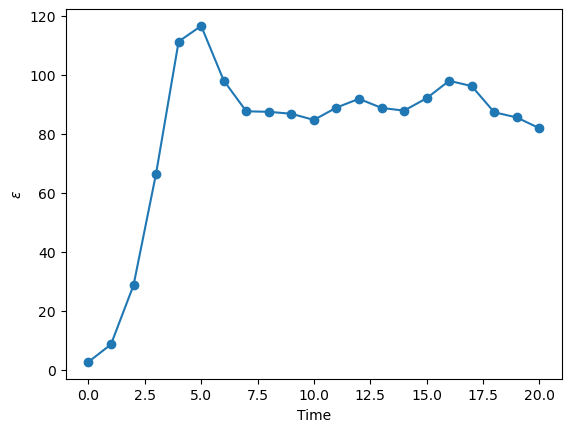

In [101]:
# plt.plot(tload,eta,'x-')
plt.plot(tload,ens/(TWO_PI**3),'o-')
# plt.plot(tload,pe,'o-')
# plt.plot(tload,pe + ke,'o-')
# plt.ylim(0,10)   
# plt.xlim(0,5.5) 
#plt.yscale('log',base = 2)
plt.xlabel('Time')

# plt.ylabel('$\Omega$')
plt.ylabel('$\epsilon$')

Text(0, 0.5, '$k_{max}\\eta$')

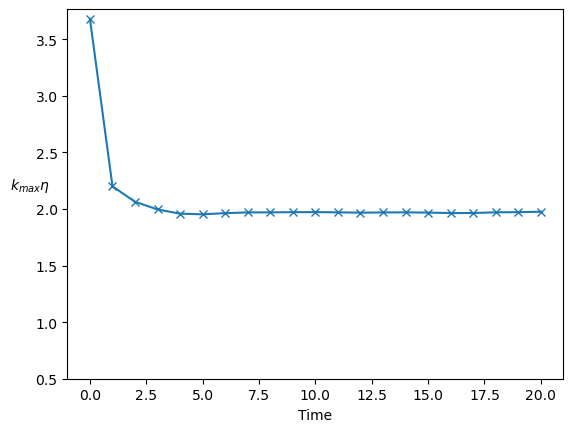

In [102]:
plt.plot(tload,eta*(N//3),'x-')
# plt.plot(tload,pe,'o-')
# plt.plot(tload,pe + ke,'o-')
# plt.ylim(0,2)   
plt.ylim(0.5,None) 
# plt.yscale('log',base = 2)
plt.xlabel('Time')
plt.ylabel('$k_{max}\eta$',rotation = 0)

# <center> Energy Spectrum

In [66]:
cls = sns.color_palette("Set1", len(times[-1:]))
cls

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

446.3451380599492ime: 18.0


/tmp/ipykernel_383786/748398478.py:20: RuntimeWarning: divide by zero encountered in power
  ydat = 1.6*dissip**(2/3)*k1d**(-5/3)
/tmp/ipykernel_383786/748398478.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc ='lower left')


(1, 52)

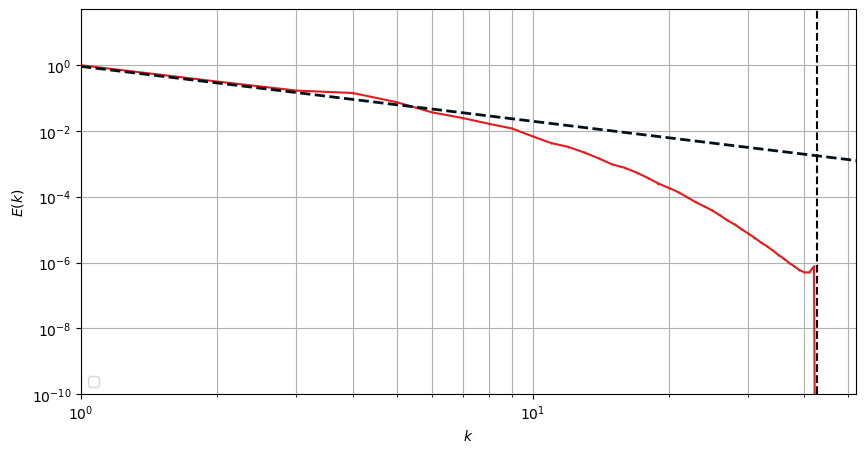

In [68]:
plt.figure(figsize = (10,5))
k1d = np.arange(Nf).astype(np.float64)
xdat = 0.
ydat = 0.
count = 0.
for i,t in enumerate(times[18:19]):
    print('Loding Done for time:',t,end = '\r')
    ek =  np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]/TWO_PI**3
    dissip = 2*nu*np.sum(k1d**(2*lp)*ek)
    eta = (nu**3/ dissip)**0.25
    # print(eta,ek.sum(),eta/(TWO_PI/N),N//3*eta,dissip)
    count += 1
    xdat += k1d[:]
    ydat += ek[:]
xdat = xdat/count
ydat = ydat/count
print(np.sum(ydat)*TWO_PI**3)
plt.plot(xdat[1:],ydat[1:],".-", color = cls[0],markersize = 1)
    
ydat = 1.6*dissip**(2/3)*k1d**(-5/3)
plt.plot(xdat[1:],ydat[1:],'--',lw = 2,color = "#001219")
line = np.array([1.2,100])
# plt.plot(line,1e3*line**(-3.),"--",color = "black")
# plt.text(5,80,r"$k^{-3}$",fontsize = 12)
# plt.plot(line,1e2*line**(-5/3.),"--",color = "black")
# plt.text(20,80,r"$k^{-\frac53}$",fontsize = 12)

plt.axvline(1/3*N, linestyle='--', color='black')
# plt.text(int(1/3*N*0.85), 10, r'$\frac{N}{3}$', fontsize=12)  # Add text label
# plt.axvline(Nd, linestyle='--', color='black')
# plt.text(Nd*0.8, 10, r'$\frac{N}{\sqrt{3}}$', fontsize=12)  # Add text label
# plt.axhline(5e-5, linestyle='--', color='black')
# plt.text(1, 1.5*5e-5, r'$k^2$', fontsize=12)  # Add text label

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$E(k)$")
plt.legend(loc ='lower left')
plt.grid(which = "both")

plt.ylim(1e-10,None)
plt.xlim(1, N//3+10)


In [47]:
plt.figure(figsize = (10,5))
k1d = np.arange(Nf).astype(np.float64)
count = 0
dissip = 0
pi = 0
for i,t in enumerate(times[-5:]):
    print('Loding Done for time:',t,end = '\r')
    pik =  np.load(loadPath(t)/f"Flux_spectrum.npz")["Pik"]/TWO_PI**3 # Pi at dealias + 1 has to be zero 
    # pik =  np.roll(np.load(loadPath(t)/f"Flux_spectrum.npz")["Pik"]/TWO_PI**3,-1) # Pi at dealias has to be zero 
    ek =  np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]/TWO_PI**3
    dissip += 2*nu*np.sum(ek*k1d**(2*lp))
    print(np.sum(k1d)**(2*6))
    xdat = k1d
    pi += pik
    count+= 1
    # ydat += pi/dissip

ydat = pi/dissip
plt.plot(xdat,ydat,".-",label = f"t = {t:.0f}", color = cls[0],markersize = 1)
    
plt.axvline(1/3*N, linestyle='--', color='black')
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$\Pi(k)/\epsilon$")
plt.legend(loc ='lower left')
plt.grid(which = "both")

plt.ylim(1e-8,None)
plt.xlim(1, N//3+10)


: 

In [ ]:
k = k1d
ek_avg = 

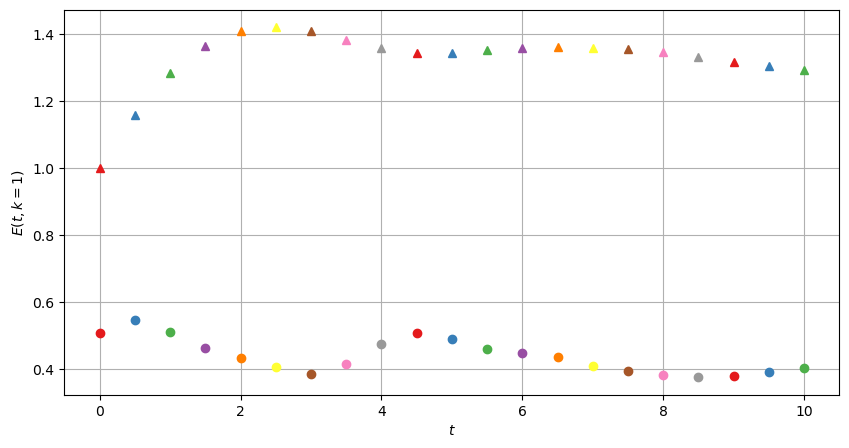

In [30]:
plt.figure(figsize = (10,5))
k1d = np.arange(Nf)
for t in times:
    print('Loding Done for time:',t,end = '\r')
    e1 =  np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"][1]/(TWO_PI**3)
    et = np.sum(np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]/(TWO_PI**3))
    xdat = t
    ydat = e1
    plt.plot(xdat,ydat,"o", color = cls[times.index(t)])
    ydat = et
    plt.plot(xdat,ydat,"^", color = cls[times.index(t)])
    
plt.xlabel(r"$t$")
plt.ylabel(r"$E(t,k =1)$")
# plt.legend(loc ='best')
plt.grid(which = "both")



# <center> Structure Function

In [7]:
p = 1
r = dx*np.arange(Nf)

In [8]:
color = ["264653","2a9d8f","e9c46a","f4a261","e76f51"]

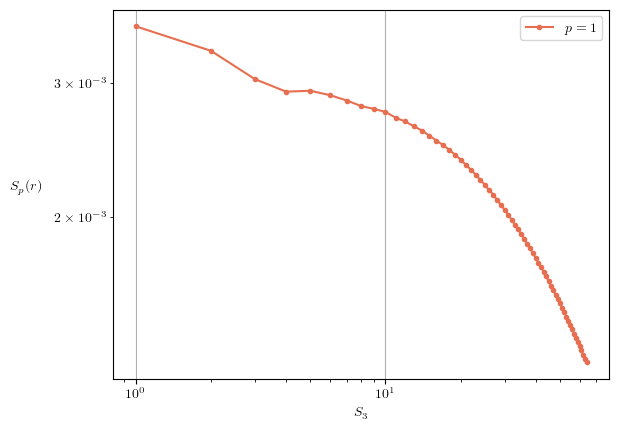

In [15]:
for p in range(1,2):
    sfunc = np.load(f"/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/struct-func-{p:.1f}-N-{N}.npy")
    # s3 = np.load(f"/mnt/pfs/rajarshi.chattopadhyay/codes/3D-DNS/pstprc_data/struct-func-{3:.1f}-N-512.npy")
    # poly = np.polyfit(np.log(s3[1:]),np.log(sfunc[1:]),1)
    # print(poly[0],p/3)
    line1 = np.array([1,20])
    line2 = np.array([30,256])
    cls = "#" + color[-p]
    plt.plot(r[1:]/dx,sfunc[1:]*(r[1:]**(-p)),'.-',label = f"$p = {p}$",color =cls)
    # plt.plot(s3[1:],(sfunc[1:] - sfunc[:-1])/(s3[1:]-s3[:-1]),'.-',label = f"Slope $ p = {p}$",color =cls )
    # plt.plot(line1,5e-2*line1**(p),"--",color =cls)
    # plt.plot(line2,5e-2*line2**(p/3),"--",color =cls)
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.xlim(1e-7,1e-3)
# plt.ylim(1e-9,1e-1)
plt.xlabel(r"$S_3$")
plt.ylabel(r"$S_p(r)$",rotation = 0,labelpad = 20)
# plt.ylabel(r"Slope",rotation = 0,labelpad = 20)
plt.grid()